# Steve requested camera video orientation to be normalised to direction of L-DED travel

This notebook explores how to do that

In [28]:
import sys
import os
import importlib # Used during testing if I need to reload modules
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats

In [29]:
try:
    import ngif_romar.tools as tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join(".."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools

In [30]:
dataset_path = os.path.join("../", "data", "SN5", "20201022_1359_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, df = tools.read_data(logfile_path)

In [31]:
# Check it's working
df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,revolutionSpeed_1,powderGasFlow_1,stirrerValue_2,revolutionSpeed_2,powderGasFlow_2,flowWatch,meltpoolThreshold,protectionGlasTemperature
0,30358,0.0,0.0,0.0,0.0,0.0,7082,1711.0,2000,0,0,0,500,400,600,2896,506,19.3
1,30458,0.0,0.0,0.0,0.0,0.0,7204,1709.0,2000,0,0,0,500,400,600,2896,506,19.3
2,30558,0.0,0.0,0.0,0.0,0.0,7254,1727.0,2000,0,0,0,500,400,600,2896,506,19.3
3,30658,0.0,0.0,0.0,0.0,0.0,7183,1728.0,2000,0,0,0,500,400,600,2896,506,19.3
4,30758,0.0,0.0,0.0,0.0,0.0,7604,1720.0,2000,0,0,0,500,400,600,2896,506,19.3


In [32]:
def unique(v):
    unqs = []
    for i in v:
        if i not in unqs:
            unqs.append(i)
    return unqs

In [33]:
# add in post processing goodies
orig_cols = df.columns
#print("Dataframe originally has these columns:"); print(df.columns)
df = tools.post_process_log_data(df)
new_cols = df.columns
print("Post-processing adds the following variables to the data:"); print(set(new_cols) ^ set(orig_cols))

Post-processing adds the following variables to the data:
{'|v|(mm/ms)', 'phi_dot(rad/ms)', 'xpart', 'v_z(mm/ms)', 't(min)', 'phi(rad)', 'r(mm)', 'zpart', 'ypart', 'v_x(mm/ms)', 'v_y(mm/ms)', 'laser_on_time(ms)', 't(s)', 'laser_off_time(ms)', 'toolpath_key'}


Now link the entries to the matching camera frames

In [34]:
frames_path = os.path.join("../","data","SN5","20201022_1359_","Frames")
df = tools.link_camera_frames_to_df(df, frames_path)

Plotting a single frame, example

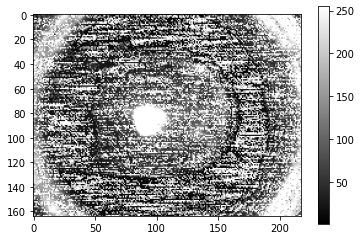

In [35]:
f1000_path=frames_path+'/'+os.listdir(frames_path)[1000]
f1000=tools.read_and_convert_image(f1000_path)

fig, ax = plt.subplots()
i0 = ax.imshow(f1000,cmap='gray')
fig.colorbar(i0)
plt.show()

There are more camera frames than data points. How many?

In [36]:
len(df)/len(set(df['matching_frame_filename']))

10.007932011331444

Seems about 10 on average. We think the data is every ms, so the camera is roughly 100Hz.

Camera goes up to 127 Hz => shutter speed can be as low as ~7.87ms. Same ballpark as the ~10*(1 ms measurements) between frames.
Without more information I'll use the above as justification to average the frames to find the velocity

In [37]:
# test
unqframes=unique(df['matching_frame_filename'])
framenumber = unqframes[1000] # arbitrary
subset = df[df['matching_frame_filename']==framenumber]
subset.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
10004,1030760,30.579,22.391,91.760,0.0,0.0,11852,1856.0,1750,0,...,0.632034,37.900292,-0.000514,959002,0,30.579,22.391,91.760,1.0,20201022_141614__1031240.dat
10005,1030860,31.442,21.164,91.762,0.0,0.0,11641,1854.0,1750,0,...,0.592452,37.901375,-0.000396,959102,0,31.442,21.164,91.762,1.0,20201022_141614__1031240.dat
10006,1030960,32.254,19.903,91.765,0.0,0.0,11693,1851.0,1750,0,...,0.552877,37.900527,-0.000396,959202,0,32.254,19.903,91.765,1.0,20201022_141614__1031240.dat
10007,1031060,33.016,18.611,91.767,0.0,0.0,12052,1858.0,1750,0,...,0.513298,37.900206,-0.000396,959302,0,33.016,18.611,91.767,1.0,20201022_141614__1031240.dat
10008,1031160,33.726,17.290,91.770,0.0,0.0,11694,1856.0,1750,0,...,0.473725,37.899699,-0.000396,959402,0,33.726,17.290,91.770,1.0,20201022_141614__1031240.dat


# Goal = orient frames such that 'up' = the y axis and 'right' = the x axis
Axes defined in the room-frame, not part-frame

In [38]:
avg_vx, avg_vy, avg_vz = np.mean(subset[['v_x(mm/ms)','v_y(mm/ms)','v_z(mm/ms)']])

All velocities are in mm/ms, but we only need their relative values here. In fact, v_z is irrelevant because we have a top-down POV. We could make the orientation arbitrary (in which case v_z could be needed) but I don't foresee anyone wanting this.

We can get the angle we want for this orientation from np.arctan2(-vx,+vy). The diagram below explains:
![alt text](\figs\camera-orientation-explanation.png)

In [39]:
ang1000 = np.arctan2(-avg_vx,avg_vy) # -vy, +vy in that order such that y axis is on the right

Angle comes out in radians. This is the velocity angle in the desired reference frame, so to change frames we rotate by the opposite angle.

# Angle obtained, now to rotate the frame.

Note that when we rotate, we can lose parts of the image due to hitting the boundary. This can be avoided by changing the size of the image.
I think extending the boundaries will be better for human viewing. However it could be needless and potentially unhelpful for counting meltpoolSize

In [40]:
import imutils
r1000 = imutils.rotate(f1000, angle=ang1000*180/np.pi) # lose out-of-bounds
rb1000 = imutils.rotate_bound(f1000, angle=ang1000*180/np.pi) # convert to degrees

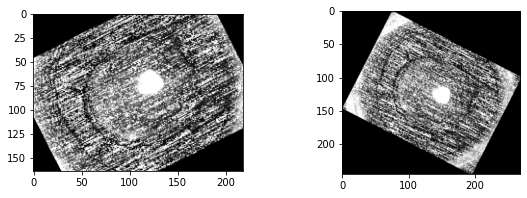

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))
ir0 = ax1.imshow(r1000, cmap='gray')
irb0 = ax2.imshow(rb1000,cmap='gray')
plt.subplots_adjust(wspace=0.4)
plt.show()

Personally I think not-cropping will look better to the human observer.

Changing the bounding box changes the size of the image - could be annoying later.

In [42]:
print("Shape of original image (as an array): ",np.shape(f1000))
print("Shape of bounded, rotated image: ",np.shape(r1000))
print("Shape of unbounded, rotated image: ", np.shape(rb1000))

Shape of original image (as an array):  (164, 218)
Shape of bounded, rotated image:  (164, 218)
Shape of unbounded, rotated image:  (245, 268)


# How does it look on video?